In [2]:
import pandas as pd
from datetime import datetime
from osgeo import gdal
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from dateutil.parser import parse
import subprocess
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models

from os import listdir
from os.path import isfile, join

In [2]:
MAIAC_TRAINING_DATA_PATH = "./Data/maiac_satellite_data/train/"
TRAINING_LABELS_CSV_PATH = "./Data/train_labels.csv"
SATELLITE_METADATA_CSV_PATH = "./Data/satellite_metadata.csv"
GRID_METADATA_CSV_PATH = "./Data/grid_metadata.csv"

In [3]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

### Import Competition Files

In [4]:
train_labels = pd.read_csv(TRAINING_LABELS_CSV_PATH)
grid_metadata = pd.read_csv(GRID_METADATA_CSV_PATH)
satellite_metadata = pd.read_csv(SATELLITE_METADATA_CSV_PATH)
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [38]:
test_set = satellite_metadata[satellite_metadata.split=='test']

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
4260,20170107T194500_maiac_la_0.hdf,2017-01-07T18:00:00.000Z,2017-01-07 19:45:00+00:00,maiac,la,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2869585640,8028660,2017-01-07 19:45:00+00:00
4261,20170108T202500_maiac_la_0.hdf,2017-01-08T17:05:00.000Z,2017-01-08 20:25:00+00:00,maiac,la,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,733922878,8309420,2017-01-08 20:25:00+00:00
4262,20170109T193000_maiac_la_0.hdf,2017-01-09T17:45:00.000Z,2017-01-09 19:30:00+00:00,maiac,la,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1108245170,6607599,2017-01-09 19:30:00+00:00
4263,20170110T201500_maiac_la_0.hdf,2017-01-10T18:30:00.000Z,2017-01-10 20:15:00+00:00,maiac,la,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2795589634,7824560,2017-01-10 20:15:00+00:00
4264,20170111T192000_maiac_la_0.hdf,2017-01-11T17:35:00.000Z,2017-01-11 19:20:00+00:00,maiac,la,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2365830052,10288952,2017-01-11 19:20:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7716,20210721T060842_misr_dl_0.nc,2021-07-21T05:11:48.000Z,2021-07-21 06:08:42+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3768009907,30790672,2021-07-21 06:08:42+00:00
7717,20210730T060258_misr_dl_0.nc,2021-07-30T05:11:45.000Z,2021-07-30 06:02:58+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2262052656,29487879,2021-07-30 06:02:58+00:00
7718,20210806T060933_misr_dl_0.nc,2021-08-06T05:18:20.000Z,2021-08-06 06:09:33+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4079577923,29589362,2021-08-06 06:09:33+00:00
7719,20210815T060400_misr_dl_0.nc,2021-08-15T05:12:45.000Z,2021-08-15 06:04:00+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2932726739,32837807,2021-08-15 06:04:00+00:00


### Example MAIAC Satellite Photo

In [5]:
ds = load_data("./Data/maiac_satellite_data/train/20180207T201000_maiac_la_0.hdf")
ds.GetSubDatasets()[0]
raster = gdal.Open(ds.GetSubDatasets()[8][0]) #grid5km:cosSZA features only
band = raster.GetRasterBand(1)
band_arr = band.ReadAsArray()

In [6]:
for path, desc in ds.GetSubDatasets():
    print(desc)

[4x1200x1200] Optical_Depth_047 grid1km (16-bit integer)
[4x1200x1200] Optical_Depth_055 grid1km (16-bit integer)
[4x1200x1200] AOD_Uncertainty grid1km (16-bit integer)
[4x1200x1200] FineModeFraction grid1km (16-bit integer)
[4x1200x1200] Column_WV grid1km (16-bit integer)
[4x1200x1200] AOD_QA grid1km (16-bit unsigned integer)
[4x1200x1200] AOD_MODEL grid1km (8-bit unsigned integer)
[4x1200x1200] Injection_Height grid1km (32-bit floating-point)
[4x240x240] cosSZA grid5km (16-bit integer)
[4x240x240] cosVZA grid5km (16-bit integer)
[4x240x240] RelAZ grid5km (16-bit integer)
[4x240x240] Scattering_Angle grid5km (16-bit integer)
[4x240x240] Glint_Angle grid5km (16-bit integer)


In [7]:
example_subset = gdal.Open(ds.GetSubDatasets()[6][0])

In [8]:
example_subset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f60fefed390> >

In [9]:
#example_subset.GetRasterBand(1)

In [10]:
#example_subset.GetMetadata()

In [11]:
example_subset_array = example_subset.GetRasterBand(1).ReadAsArray()

In [12]:
example_subset_array

array([[255, 255, 255, ...,   2,   2,   2],
       [255, 255, 255, ...,   2,   2,   2],
       [255, 255, 255, ...,   2,   2,   2],
       ...,
       [  2,   2,   2, ...,   2,   2,   2],
       [  2,   2,   2, ...,   2,   2,   2],
       [  2,   2,   2, ...,   2,   2,   2]], dtype=uint8)

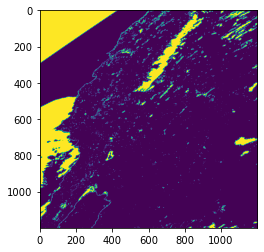

In [13]:
plt.imshow(example_subset_array)

In [14]:
example_subset_array.shape

(1200, 1200)

### Define Helper Functions

In [15]:
####################
# REMOVE THIS LINE #
####################
train_labels = train_labels.sample(4000) #random_state=42)

In [16]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [17]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [50]:
def fetch_subset(granule_id):
    ds = load_data("Data/maiac_satellite_data/test/" + granule_id)
    ds.GetSubDatasets()[0]
    raster = gdal.Open(ds.GetSubDatasets()[8][0])
    band = raster.GetRasterBand(1)
    band_arr = band.ReadAsArray()
    return band_arr

In [19]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']
        subset = fetch_subset(granule_id)
        if features is None:
            features = subset
        else:
            features+=subset
    return features/counter

In [20]:
def generate_features(train_labels, split):
    labels = []
    features = []
    for i in range(len(train_labels)):
        feature = fetch_training_features(train_labels.iloc[i]['grid_id'], train_labels.iloc[i]['datetime'], split)
        features.append(np.array(feature).reshape(-1))
        
        #features.append(np.array(feature).reshape(1200,1200,1))
        if split == "train":
            labels.append(train_labels.iloc[i]['value'])
    return np.array(features), np.array(labels)

In [21]:
features, labels = generate_features(train_labels, "train")

In [22]:
features[features<0] = np.mean(features[features>0])
#normalized_features = features/100

In [23]:
from pandas import Series
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(features)
# normalize the dataset and print
normalized_features = scaler.transform(features)

In [25]:
def baseline_model():
    model = Sequential()
    model.add(Dense(10, use_bias = True, kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(layers.Dropout(.2))
    model.add(Dense(1, activation='relu', use_bias = True, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=100, verbose=True)
estimator.fit(normalized_features, labels)
#results = cross_val_score(estimator, features, labels)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  if __name__ == '__main__':


Epoch 1/100
40/40 [==============================] - 1s 24ms/step - loss: 9364.2334
Epoch 2/100
40/40 [==============================] - 1s 21ms/step - loss: 8467.1260
Epoch 3/100
40/40 [==============================] - 1s 26ms/step - loss: 6952.2163
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 6504.1382
Epoch 5/100
40/40 [==============================] - 1s 32ms/step - loss: 6151.7266
Epoch 6/100
40/40 [==============================] - 1s 24ms/step - loss: 5931.4717
Epoch 7/100
40/40 [==============================] - 1s 27ms/step - loss: 5703.8467
Epoch 8/100
40/40 [==============================] - 1s 19ms/step - loss: 5559.1333
Epoch 9/100
40/40 [==============================] - 1s 25ms/step - loss: 5471.8569
Epoch 10/100
40/40 [==============================] - 1s 23ms/step - loss: 5249.0713
Epoch 11/100
40/40 [==============================] - 1s 31ms/step - loss: 5123.2642
Epoch 12/100
40/40 [==============================] - 1s 27ms/step - loss:

In [54]:
# model = Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1200, 1200,1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='relu'))
# model.compile(loss='mean_squared_error', optimizer='adam')

# model.fit(normalized_features, labels, epochs=10, batch_size=2)

In [26]:
predictions = estimator.predict(normalized_features)

40/40 [==============================] - 1s 15ms/step


(array([1.772e+03, 1.304e+03, 3.820e+02, 1.790e+02, 1.880e+02, 1.280e+02,
        3.400e+01, 0.000e+00, 1.200e+01, 1.000e+00]),
 array([  0.      ,  36.312855,  72.62571 , 108.93856 , 145.25142 ,
        181.56427 , 217.87712 , 254.18997 , 290.50284 , 326.81567 ,
        363.12854 ], dtype=float32),
 <BarContainer object of 10 artists>)

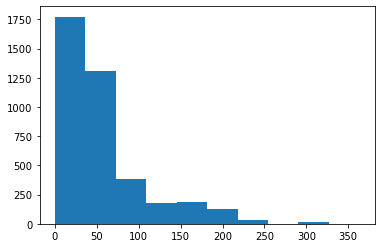

In [27]:
plt.hist(predictions)

In [31]:
import pandas as pd
ex = pd.DataFrame()
ex['p'] = predictions
ex['l'] = labels

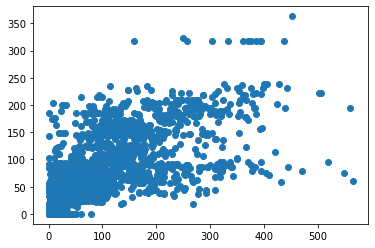

In [36]:
plt.scatter(ex['l'], ex['p'])

In [35]:
ex.sort_values(by='p').tail(100)

,p,l
616,198.116730,141.510000
2053,198.116730,289.892308
3486,198.116730,134.580400
3159,198.675903,74.575000
912,198.675903,106.694444
...,...,...
3172,317.406067,361.418182
2244,317.406067,385.058916
2417,317.406067,392.656716
1235,323.002625,250.000000


In [58]:
predictions

array([ 99.25518 ,  57.131298,  41.936714, ...,  55.74641 , 107.19492 ,
         0.      ], dtype=float32)

In [59]:
p = pd.DataFrame(predictions).sort_values(by=0)

In [60]:
p.groupby(by=0).size().sort_values().head(50)

0
49.911358    1
78.228897    1
45.602825    1
45.568966    1
45.543652    1
45.175755    1
45.137226    1
78.647766    1
45.092972    1
45.017506    1
45.008003    1
44.923279    1
44.731182    1
44.481823    1
44.370533    1
44.276833    1
44.215187    1
44.025070    1
42.651428    1
82.367607    1
82.318611    1
42.837681    1
80.988625    1
43.167656    1
77.921577    1
43.367500    1
43.511593    1
43.606602    1
43.898060    1
43.911022    1
80.635216    1
80.277191    1
43.505161    1
45.770584    1
46.063873    1
77.886330    1
47.789009    1
74.127563    1
47.973186    1
74.073853    1
73.962540    1
48.127548    1
47.711025    1
48.173195    1
48.201126    1
48.474018    1
73.506233    1
73.193939    1
48.730198    1
48.822498    1
dtype: int64

(array([4171.,  188.,  152.,  170.,  177.,   71.,   14.,   14.,   20.,
          23.]),
 array([      0.  ,  208684.97,  417369.94,  626054.9 ,  834739.9 ,
        1043424.8 , 1252109.8 , 1460794.8 , 1669479.8 , 1878164.6 ,
        2086849.6 ], dtype=float32),
 <BarContainer object of 10 artists>)

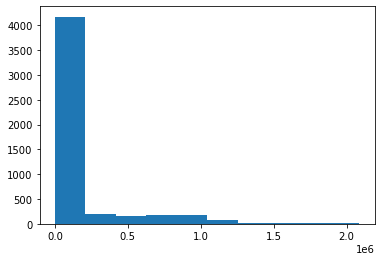

In [182]:
plt.hist(predictions)

### Submission

In [40]:
sub = pd.read_csv("./Data/submission_format.csv")

In [45]:
processed = sub.copy()

In [46]:
processed['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

In [47]:
processed

,datetime,grid_id,value,Date
0,2017-01-07T16:00:00Z,1X116,0.0,2018-02-01 19:10:00+00:00
1,2017-01-07T16:00:00Z,9Q6TA,0.0,2018-02-02 19:50:00+00:00
2,2017-01-07T16:00:00Z,KW43U,0.0,2018-02-03 20:30:00+00:00
3,2017-01-07T16:00:00Z,VR4WG,0.0,2018-02-04 19:40:00+00:00
4,2017-01-07T16:00:00Z,XJF9O,0.0,2018-02-05 20:20:00+00:00
...,...,...,...,...
13499,2021-08-24T08:00:00Z,QJHW4,0.0,NaT
13500,2021-08-24T08:00:00Z,VBLD0,0.0,NaT
13501,2021-08-24T08:00:00Z,WT52R,0.0,NaT
13502,2021-08-24T08:00:00Z,ZP1FZ,0.0,NaT


In [71]:
pred = []
for x in np.array_split(sub, 10):
    print("DONE")
    df = pd.DataFrame(x)
    features, labels = generate_features(df, "test")
    features[features<0] = np.mean(features[features>0])
    normalized_features = scaler.transform(features)
    predictions = estimator.predict(normalized_features)
    pred.extend(predictions) 

DONE
14/14 [==============================] - 0s 11ms/step
DONE
14/14 [==============================] - 0s 17ms/step
DONE
14/14 [==============================] - 0s 13ms/step
DONE
14/14 [==============================] - 0s 11ms/step
DONE
14/14 [==============================] - 0s 11ms/step
DONE
14/14 [==============================] - 0s 12ms/step
DONE
14/14 [==============================] - 0s 15ms/step
DONE
14/14 [==============================] - 0s 17ms/step
DONE
14/14 [==============================] - 0s 9ms/step
DONE
14/14 [==============================] - 0s 11ms/step


In [74]:
sub['value'] = pred

In [78]:
sub

,datetime,grid_id,value
0,2017-01-07T16:00:00Z,1X116,89.509331
1,2017-01-07T16:00:00Z,9Q6TA,89.509331
2,2017-01-07T16:00:00Z,KW43U,89.509331
3,2017-01-07T16:00:00Z,VR4WG,89.509331
4,2017-01-07T16:00:00Z,XJF9O,89.509331
...,...,...,...
13499,2021-08-24T08:00:00Z,QJHW4,84.140938
13500,2021-08-24T08:00:00Z,VBLD0,84.140938
13501,2021-08-24T08:00:00Z,WT52R,84.140938
13502,2021-08-24T08:00:00Z,ZP1FZ,84.140938


In [79]:
sub.to_csv("./Data/submission_1_ntj.csv", header=True, index=False)

In [51]:
features, labels = generate_features(sub, "test")

SystemError: <built-in function Open> returned a result with an error set

In [ ]:
estimator.predict(features)

In [44]:
test_info = sub[['datetime', 'grid_id']]

In [42]:
satellite_metadata[satellite_metadata

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7716,20210721T060842_misr_dl_0.nc,2021-07-21T05:11:48.000Z,2021-07-21 06:08:42+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3768009907,30790672,2021-07-21 06:08:42+00:00
7717,20210730T060258_misr_dl_0.nc,2021-07-30T05:11:45.000Z,2021-07-30 06:02:58+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2262052656,29487879,2021-07-30 06:02:58+00:00
7718,20210806T060933_misr_dl_0.nc,2021-08-06T05:18:20.000Z,2021-08-06 06:09:33+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4079577923,29589362,2021-08-06 06:09:33+00:00
7719,20210815T060400_misr_dl_0.nc,2021-08-15T05:12:45.000Z,2021-08-15 06:04:00+00:00,misr,dl,test,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2932726739,32837807,2021-08-15 06:04:00+00:00
